In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Reading the data.

In [ ]:
!ls ../input/liverpool-ion-switching/

In [12]:
train = pd.read_csv(r"C:\Users\sanja\Downloads\train.csv.zip")
test = pd.read_csv(r"C:\Users\sanja\Downloads\test.csv.zip")
sample = pd.read_csv(r"C:\Users\sanja\Downloads\sample_submission.csv.zip")

# Preprocessing.

In [14]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [16]:
test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [18]:
sample.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [20]:
train.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


In [ ]:
train.info()

In [ ]:
train.isnull().sum()

In [22]:
print("Shape of training data is {}".format(train.shape))
print("Shape of testing data is {}".format(test.shape))
print("Shape of sample data is {}".format(sample.shape))

Shape of training data is (5000000, 3)
Shape of testing data is (2000000, 2)
Shape of sample data is (2000000, 2)


In [24]:
dupli = train[train.duplicated()]
dupli

,time,signal,open_channels


open_channels
0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution in target column')

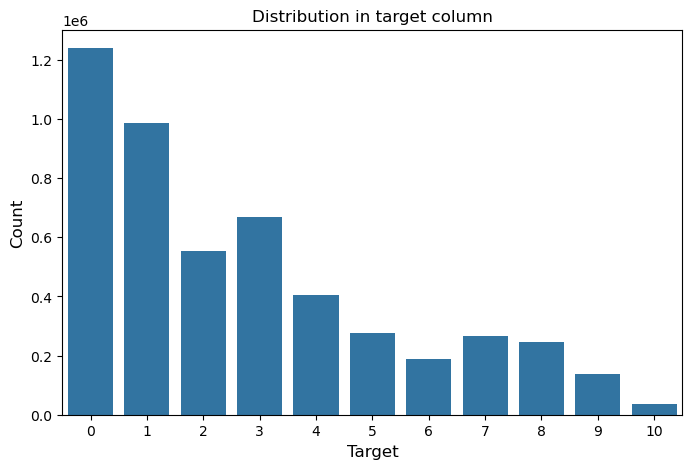

In [26]:
print(train['open_channels'].value_counts())
plt.figure(figsize = (8,5))
sns.countplot(x = train['open_channels'])
plt.xlabel('Target', size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution in target column', size = 12)

In [31]:
def Outliers(data, ft):
    IQ1 = data[ft].quantile(0.25)
    IQ3 = data[ft].quantile(0.75)
    IQR = IQ3 - IQ1
    
    upper_bound = IQ3 + 1.5 * IQR
    lower_bound = IQ1 - 1.5 * IQR
    
    ind = data.index[ (data[ft] < lower_bound) | (data[ft] > upper_bound) ]
    
    return ind

In [33]:
ind = []
for i in train.columns:
    ind.extend(Outliers(train, i))
print("Total Number of Outliers are: {}".format(len(ind)))

Total Number of Outliers are: 175446


In [35]:
# Making copy of training data to see how our data is affected by dropping outliers.

train1 = train.copy()

In [37]:
print("Shape of training data before dropping outliers is {}".format(train.shape))
train1.drop(ind, inplace = True, axis = 0)
print("Shape of cpoy of training data after dropping outliers is {}".format(train1.shape))

Shape of training data before dropping outliers is (5000000, 3)
Shape of cpoy of training data after dropping outliers is (4828147, 3)


open_channels
0    1240152
1     985865
3     668609
2     553924
4     403410
5     277877
7     265015
8     245183
6     188112
Name: count, dtype: int64


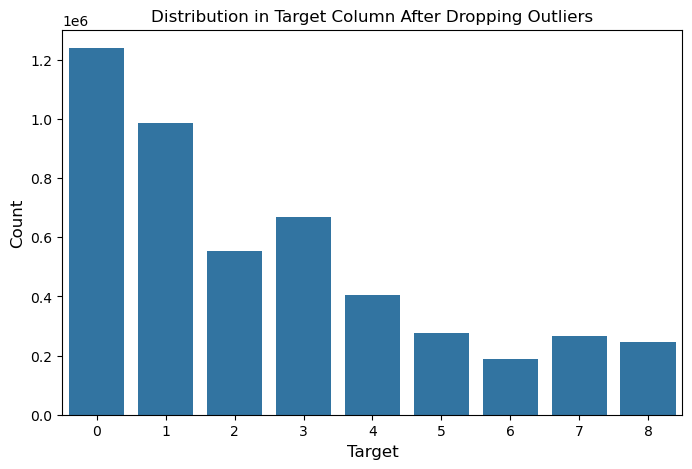

In [39]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Print value counts of the 'open_channels' column
print(train1['open_channels'].value_counts())

# Create the count plot
plt.figure(figsize=(8, 5))  # Set the figure size
sns.countplot(x='open_channels', data=train1)  # Specify x and the dataset
plt.xlabel('Target', fontsize=12)  # Set x-axis label with font size
plt.ylabel('Count', fontsize=12)  # Set y-axis label with font size
plt.title('Distribution in Target Column After Dropping Outliers', fontsize=12)  # Set the plot title
plt.show()  # Display the plot


*So here we can see that by dropping outliers we are loosing important information. So we will not drop Outliers.*

In [40]:
x = train.iloc[:, :-1]
col = x.columns

std = StandardScaler()
x_std = std.fit_transform(x)
x_std = pd.DataFrame(data = x_std, columns = col)

mms = MinMaxScaler()
x_mms = mms.fit_transform(x)
x_mms = pd.DataFrame(data = x_mms, columns = col)

In [28]:
y = train.iloc[:, -1]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: open_channels, dtype: int64

# Building Models.

In [50]:
def Models(d, model, name, xtrain, xtest, ytrain, ytest):
    cla = model
    print("Working with {}".format(name))
    cla.fit(xtrain, ytrain)
    
    predicted = cla.predict(xtrain)
    train_acu = accuracy_score(predicted, ytrain)
    
    predicted = cla.predict(xtest)
    test_acu = accuracy_score(predicted, ytest)
    
    F1_score = f1_score(predicted, ytest, average = 'macro')
    
    d['Name'].append(name)
    d['Train_acu'].append(train_acu)
    d['Test_acu'].append(test_acu)
    d['F1_score'].append(F1_score)
    print("********"*7)
    return d

In [52]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
l = [x, x_std, x_mms]
name = ['Normal', 'Standard Scaler', 'Min Max Scaler']
final = []

# Iterate over scaled datasets
for idx, i in enumerate(l):
    # Split data into train and test sets
    xtrain, xtest, ytrain, ytest = train_test_split(i, y, test_size=0.25, random_state=42)
    
    # Initialize a dictionary to store results for each scaling method
    d = {'Name': [], 'Train_acu': [], 'Test_acu': [], 'F1_score': []}
    
    # List of models with their names
    models = [
        [RandomForestClassifier(n_estimators=5), 'Random Forest'],
        [DecisionTreeClassifier(), 'Decision Tree'],
        [XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss'), 'XGBoost'],
        [CatBoostClassifier(task_type='GPU', verbose=0), 'CatBoost'],
        [LogisticRegression(max_iter=1000), 'Logistic Regression']
    ]
    
    # Train each model and update the results dictionary
    for model, model_name in models:
        d = Models(d, model, model_name, xtrain, xtest, ytrain, ytest)
    
    # Add results to the final list
    d['Scaling Method'] = name[idx]  # Include the scaling method's name
    final.append(d)

    # Train each model and update the results dictionary
    for model, model_name in models:
        d = Models(d, model, model_name, xtrain, xtest, ytrain, ytest)
    
    # Add results to the final list
    d['Scaling Method'] = name[idx]  # Include the scaling method's name
    final.append(d)


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
for i in range (3):
    print(name[i])
    acu = pd.DataFrame(data = final[i])
    print(acu)
    print("******************"*3)

*Taking random forest since we are getting best results.*

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [ ]:
cla = RandomForestClassifier(n_estimators = 5)
cla.fit(xtrain, ytrain)

# Making predictions on traning data.

In [54]:
x_test = test.loc[:,:]
x_test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [56]:
predicted = cla.predict(x_test)
predicted

NameError: name 'cla' is not defined

In [58]:
sample.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [60]:
'500.0010' in test['time']

False